In [1]:
import cv2
import subprocess
import matplotlib.pyplot as plt
import tempfile
import imageio.v3 as iio
import numpy as np
import os
from tqdm.auto import tqdm
from scipy.signal import savgol_filter

In [2]:
ROOT = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input/Novy Manipulator/GX010006_cely zavit_std nastaveni.MP4"
# Find out the proper crop
y1 = 550
y2 = 1800
x1 = 1400
x2 = 2650

In [6]:
frame_angles = []
hists = []

vidcap = cv2.VideoCapture(ROOT)

frame_rate = 1

total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

frames = np.zeros((total_frames, int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))), dtype=np.uint8)

for i in tqdm(range(total_frames),  desc="Processing frames"):
    success, frames[i] = vidcap.read()

MemoryError: Unable to allocate 138. GiB for an array with shape (17807, 2160, 3840) and data type uint8

In [170]:
vidcap = cv2.VideoCapture(ROOT)
vidcap.set(cv2.CAP_PROP_POS_FRAMES, 1800)
success, frame = vidcap.read()

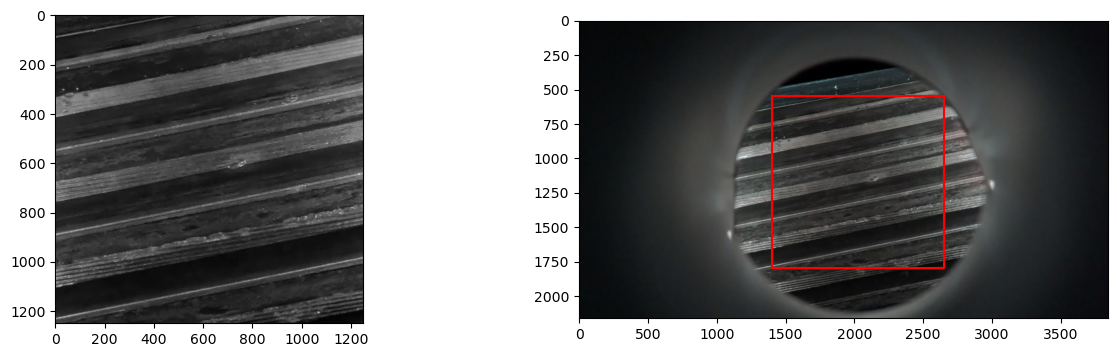

In [166]:
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.imshow(frame[y1:y2, x1:x2,0], cmap="gray")
ax = plt.subplot(122)
ax.imshow(frame)
ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="red")
plt.show()

In [3]:
def unixPathToWinPath(path):
    return path.replace("/mnt/c/", "C:/").replace("/", "\\\\")

def winPathToUnixPath(path):
    return path.replace("\\", "/").replace("C:/", "/mnt/c/")

In [4]:
frame_angles = []
hists = []

vidcap = cv2.VideoCapture(ROOT)

frame_rate = 1

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in tqdm(range(75, 105, frame_rate),  desc="Processing frames"):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = vidcap.read()
    undistorted =  frame[500:1800, 1300:2600, 0]
    undistorted = cv2.resize(undistorted, (undistorted.shape[0]//4, undistorted.shape[1]//4))
    otsu_threshold, _ = cv2.threshold(undistorted, 0, 255, cv2.THRESH_OTSU)
    
    with tempfile.NamedTemporaryFile(suffix=".pgm", delete=False) as tmpfile:
        filename = tmpfile.name
        iio.imwrite(tmpfile.name, undistorted)  # this must be a grayscale image
        
        output_path = tmpfile.name.replace(".pgm", ".txt")
        
        process = subprocess.Popen(
            ["wsl", "devernay", winPathToUnixPath(tmpfile.name),
             "-t", winPathToUnixPath(output_path),
             "-l", f"{otsu_threshold / 15}",
             "-h", f"{otsu_threshold / 3}",
             # "-p", f"/mnt/c/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/sample{i}.pdf",
             "-s", f"1"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        tmpfile.close()
        
    # Wait for the process to complete and get stdout and stderr
    stdout, stderr = process.communicate()
    
    # Check for errors in stderr
    if stderr:
        print("Error running devernay:", stderr.decode("utf-8"))
    if os.path.exists(output_path):
        with open(output_path, 'r') as output_file:
            result = output_file.read()
    else:
        print(f"Output file {output_path} does not exist.")

    lines = result.split("\n")
    dev = []
    for line in lines:
        if line != "":
            x, y = line.split(' ')
            dev.append((float(x), float(y)))
    dev = np.array(dev)
    if len(dev) == 0:
        print("Something wrong happen")
    samples = 1000
    choice = np.random.randint(0, len(dev), samples)
    xx0 = np.matmul(dev[choice, 0].reshape(-1, 1), np.ones((1, len(choice))))
    yy0 = np.matmul(dev[choice, 1].reshape(-1, 1), np.ones((1, len(choice))))
    xx1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 0].reshape(1, -1))
    yy1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 1].reshape(1, -1))
    valid = np.zeros_like(xx0, dtype=bool)
    valid[xx0 != xx1] = 1
    angles = np.zeros_like(xx0, np.float32)
    angles[xx0 == xx1] = np.pi / 2
    angles[valid] = np.arctan((yy0[valid] - yy1[valid]) / (xx0[valid] - xx1[valid])).reshape(-1)
    angles[np.eye(samples, dtype=bool)] = np.nan

    filtered = np.rad2deg(np.abs(angles[~np.isnan(angles)]))

    if filename is not None and os.path.exists(filename):
        os.remove(filename)

    # counts, values = np.histogram(filtered, bins=samples)
    hists.append(filtered)
    # frame_angles.append(values[np.argmax(counts)])

Processing frames:   0%|          | 0/30 [00:00<?, ?it/s]

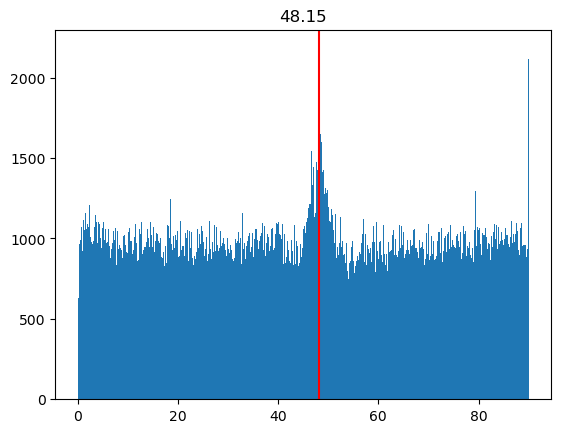

In [46]:
fid = 31
counts, values = np.histogram(hists[fid], bins=samples)
best = values[np.argmax(counts)]
plt.hist(hists[fid], bins=samples)
plt.axvline(best, color="red")
plt.title(best)
plt.show()

In [90]:
frame_angles_smoothed = []
for hist in hists:
    counts, values = np.histogram(hist, bins=samples)
    # todo Convulate histograms = denoising
    max_index = np.argmax(counts)
    
    if values[max_index] > 89.90:
        counts[max_index] = -1
        max_index = np.argmax(counts)
        if values[max_index] >= 89:
            frame_angles_smoothed.append(89.91)
        elif values[max_index] == 0:
            counts[max_index] = -1
            max_index = np.argmax(counts)
            if values[max_index] < 0.1:
                frame_angles_smoothed.append(0)
            else:
                frame_angles_smoothed.append(values[max_index])
        else:
            frame_angles_smoothed.append(values[max_index])
    elif values[max_index] == 0:
        counts[max_index] = -1
        max_index = np.argmax(counts)
        if values[max_index] < 0.1:
            frame_angles_smoothed.append(0)
        elif values[max_index] >= 89:
            counts[max_index] = -1
            max_index = np.argmax(counts)
            if values[max_index] >= 89.8:
                frame_angles_smoothed.append(89.91)
            else:
                frame_angles_smoothed.append(values[max_index])
        else:
            frame_angles_smoothed.append(values[max_index])
    else:
        frame_angles_smoothed.append(values[max_index])

In [91]:
frame_angles_smoothed = np.array(frame_angles_smoothed)

In [92]:
len(frame_angles_smoothed)

60

In [93]:
np.max(frame_angles_smoothed)

48.24

In [94]:
np.where(frame_angles_smoothed == np.max(frame_angles_smoothed))

(array([0, 4], dtype=int64),)

In [95]:
np.min(frame_angles_smoothed)

41.58

In [96]:
np.where(frame_angles_smoothed == np.min(frame_angles_smoothed))

(array([59], dtype=int64),)

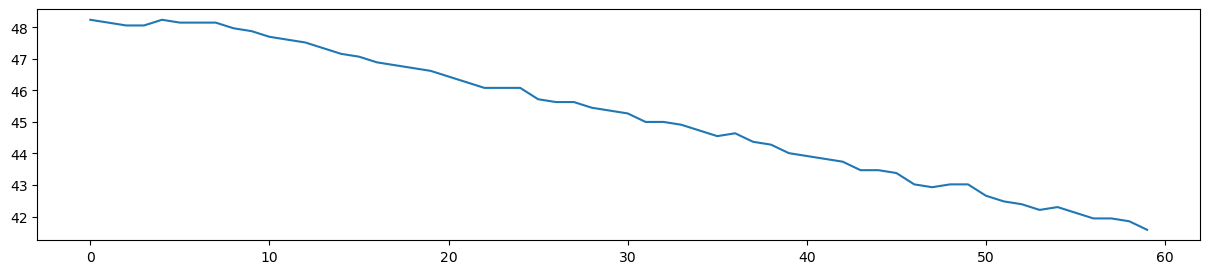

In [97]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [103]:
frame_angles_smoothed_smoothed = savgol_filter(frame_angles_smoothed, window_length=11, polyorder=1)  # Adjust window_length and polyorder based on your data

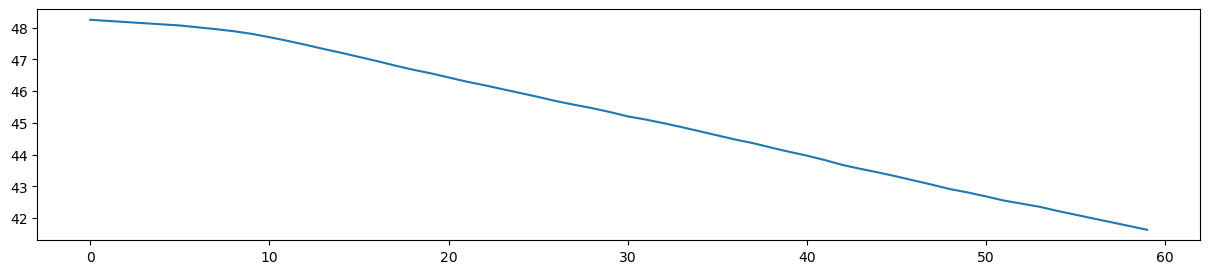

In [104]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [105]:
derivative = np.diff(frame_angles_smoothed_smoothed)
threshold = 0.04 # Adjust this threshold based on your data

segment_type = np.zeros_like(derivative)  # Array to store classification: -1 for decreasing, 0 for constant, 1 for increasing

segment_type[derivative > threshold] = 1  # Increasing
segment_type[derivative < -threshold] = -1  # Decreasing
# Constant parts are already set to 0


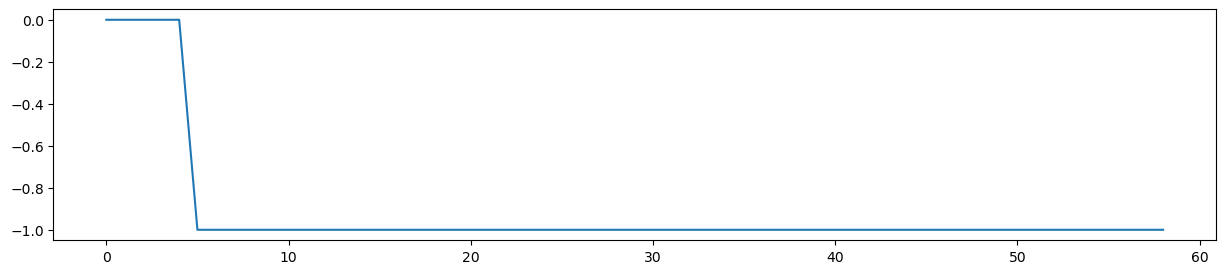

In [106]:
plt.figure(figsize=(15,3))
plt.plot(segment_type)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [107]:
breakpoints = (np.where(np.diff(segment_type) != 0)[0] + 1) * frame_rate  # +1 because np.diff shifts indices by 1

In [108]:
breakpoints

array([200], dtype=int64)

In [201]:
threshold_distance = 10  # Define the distance threshold to group close breakpoints

# Initialize list for storing the merged breakpoints
merged_breakpoints = []

# Temporary group for close breakpoints
current_group = [breakpoints[0]]

# Iterate over the breakpoints
for i in range(1, len(breakpoints)):
    # If the difference between consecutive breakpoints is below the threshold, group them
    if breakpoints[i] - breakpoints[i - 1] <= threshold_distance:
        current_group.append(breakpoints[i])
    else:
        # If current group is finished, calculate the rounded average and store it
        avg_breakpoint = int(round(np.mean(current_group)))
        merged_breakpoints.append(avg_breakpoint)
        # Start a new group
        current_group = [breakpoints[i]]

# Handle the last group
if current_group:
    avg_breakpoint = int(round(np.mean(current_group)))
    merged_breakpoints.append(avg_breakpoint)

# Now merged_breakpoints contains the final list of unique breakpoints
print("Merged Breakpoints:", merged_breakpoints)


Merged Breakpoints: [3, 24, 59, 94, 129, 3080]


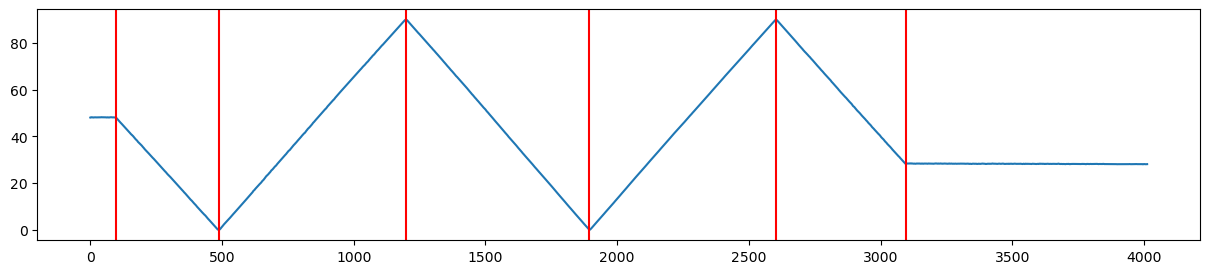

In [60]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
plt.axvline(98, color="red")
plt.axvline(487, color="red")
plt.axvline(1198, color="red")
plt.axvline(1895, color="red")
plt.axvline(2603, color="red")
plt.axvline(3095, color="red")
plt.show()

In [61]:
np.max(frame_angles_smoothed)

89.87399987792966

In [62]:
frame_angles_smoothed[3090:3100]

array([28.78199959, 28.63799973, 28.49399986, 28.40400009, 28.33200035,
       28.29600029, 28.33200035, 28.36800041, 28.36800041, 28.38600044])

In [63]:
np.where(np.array(frame_angles_smoothed)==np.min(frame_angles_smoothed))

(array([486, 488], dtype=int64),)

In [64]:
np.where(np.array(frame_angles_smoothed)==np.max(frame_angles_smoothed))

(array([1197, 1199, 2603], dtype=int64),)

In [150]:
fa = frame_angles_smoothed[merged_breakpoints[0]:merged_breakpoints[1]] * -segment_type[(merged_breakpoints[0]+merged_breakpoints[1])//2]
for i in range(1, len(merged_breakpoints)-1):
    f = frame_angles_smoothed[merged_breakpoints[i]:merged_breakpoints[i+1]] * -segment_type[(merged_breakpoints[i]+merged_breakpoints[i+1])//2] - (i//2 * 180)
    fa = np.concatenate([fa, f])

In [151]:
# fa = np.concatenate([frame_angles_smoothed[96:488], -frame_angles_smoothed[488:1198], -180 + frame_angles_smoothed[1198: 1895], -180 - frame_angles_smoothed[1895: 2603], -360 + frame_angles_smoothed[2603: 3095]])
a, b = np.polyfit(np.arange(len(fa)), fa, 1)

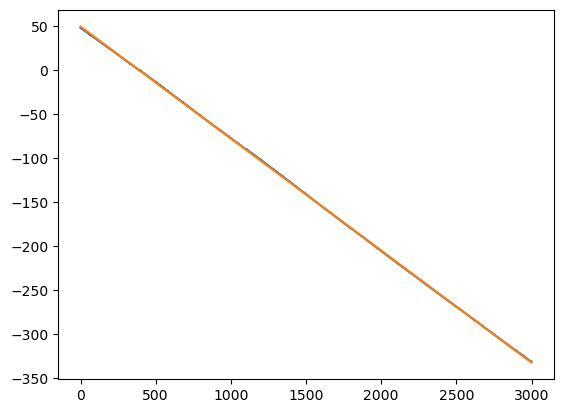

In [152]:
plt.plot(fa)
plt.plot([(a*x + b) for x in np.arange(len(fa))])
plt.show()

In [44]:
rot = -a
angle = -rot*(487-98)
rotated = []

vidcap = cv2.VideoCapture(ROOT)

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = 3095-98

success, frame = vidcap.read()

vidcap.set(cv2.CAP_PROP_POS_FRAMES, 98)

out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*'h264'),
                      fps=20.0,
                      frameSize=(y2-y1, x2-x1),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ]
                      )

for i in tqdm(range(total_frames), desc="Processing frames"):
    success, frame = vidcap.read()
    rotate_matrix = cv2.getRotationMatrix2D((frame.shape[1]/2, frame.shape[0]/2), angle, 1)    
    rotated_image = cv2.warpAffine( 
        src=frame, M=rotate_matrix, dsize=(frame.shape[1], frame.shape[0]))[y1: y2, x1:x2, 0]
    
    out.write(rotated_image.astype(np.uint8))
    
    angle += rot
    
out.release()

Processing frames:   0%|          | 0/2997 [00:00<?, ?it/s]

In [101]:
# Define the codec and create VideoWriter object
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*"H264"),
                      fps=10.0,
                      frameSize=(rotated[0].shape[1], rotated[0].shape[0]),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ])
for frame in tqdm(rotated):
    out.write(frame.astype(np.uint8))
out.release()


  0%|          | 0/1402 [00:00<?, ?it/s]

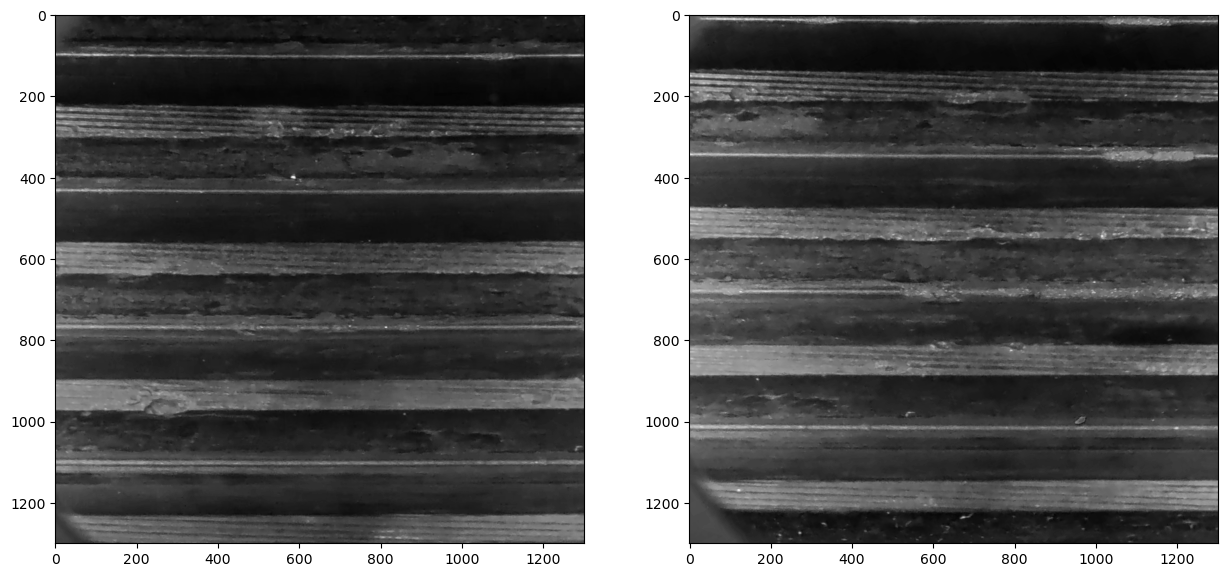

In [100]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(121)
ax.imshow(rotated[10], cmap="gray")
ax = plt.subplot(122)
ax.imshow(rotated[200], cmap="gray")
plt.show()

In [129]:
np.max(rotated)

ValueError: zero-size array to reduction operation maximum which has no identity

In [179]:
rot

0.12766499974009662